In [3]:
import sys
sys.path.append('../..')
import pandas as pd
import pandas.arrays as pdarray
from src.cleaning import integrity_checks
import src.cleaning.schema_anon_data as anon_data_schema
import numpy as np
import src.cleaning as clean
import matplotlib.pyplot as plt

In [4]:
sales_data = pd.read_csv('../../data/anon_data.csv')

C:\Users\C\AppData\Local\Temp\ipykernel_18824\750784506.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_data = pd.read_csv('../../data/anon_data.csv')


In [5]:
sales_data.dtypes

CustomerId                int64
SalesOrderNumber         object
SalesOrderLineNumber      int64
ShipDate                 object
Qty                      object
Brand                    object
ProductType              object
ProductSupplierID       float64
Revenue                 float64
Profit                  float64
Freight cost            float64
SalesTeamName            object
dtype: object

In [6]:
# Can columns be converted to appropriate data types?
file_schema = {
  'CustomerId': int,
  'SalesOrderNumber': int,
  'SalesOrderLineNumber': int,
  'Qty': int,
  'Brand': 'string',
  'ProductType': 'string',
  'ProductSupplierID': int,
  'Revenue': float,
  'Profit': float,
  'Freight cost': float,
  'SalesTeamName': 'string',
}
failing_columns = list()
for column_name, column_type in file_schema.items():
    try:
        if column_type in [int, float]:
            pd.to_numeric(sales_data[column_name])
        sales_data[column_name].astype(column_type)
    except Exception as e:
        failing_columns.append(column_name)
for i in failing_columns:
    print(i)

# SalesOrderNumber is due to preceeding O instead of 0
# Qty is because of commas in numbers e.g. 1,000
# ProductSupplierId is because of Null values

# Data requires cleaningand formatting before proceeding on further investigation

SalesOrderNumber
Qty
ProductSupplierID


In [7]:
sales_data.isna().sum()
# Nulls in:
# Brand: Problem as don't know the item being sold
# Product Type: Problem as don't know the item being sold
# Product Supplier Id: Not a problem is some stuff is refurbished or refunded and then resold?
                        # Question to ask

CustomerId                 0
SalesOrderNumber           0
SalesOrderLineNumber       0
ShipDate                   0
Qty                        0
Brand                     81
ProductType               81
ProductSupplierID       2288
Revenue                    0
Profit                     0
Freight cost               0
SalesTeamName              0
dtype: int64

In [8]:
# Are null brands the same rows as null product type?
brand_nulls = sales_data.loc[sales_data['Brand'].isna(), :].index
product_type_nulls = sales_data.loc[sales_data['ProductType'].isna(), :].index
(brand_nulls == product_type_nulls).all()
# Yes so removing one will also solve the other

True

In [9]:
# Data type enforced data
data_schema = anon_data_schema.schema
typed_data = data_schema.enforce_schema(dataframe=sales_data)

In [10]:
typed_data.dtypes

customer_id                         int32
sales_order_number                  int32
sales_order_line_number             int32
ship_date                  datetime64[ns]
quantity                            int32
brand                      string[python]
product_type               string[python]
product_supplier_id        string[python]
revenue                           float64
profit                            float64
freight_cost                      float64
sales_team_name            string[python]
dtype: object

In [11]:
# Check uniqueness before and after
sales_data.nunique()


CustomerId                3323
SalesOrderNumber        376671
SalesOrderLineNumber       105
ShipDate                   567
Qty                        860
Brand                      337
ProductType                423
ProductSupplierID          330
Revenue                 487715
Profit                  487923
Freight cost              8898
SalesTeamName                8
dtype: int64

In [ ]:
typed_data.nunique()
# Qty uniqueness has decreased as numbers that contained commas are now actual numbers so more likely to exist already, e.g. 1000
# SalesOrderNumber uniqueness decreased as some floats are read in as strings and some as number, example give below. So when standardised, uniqueness decreases

In [ ]:
# Describe the data
typed_data.describe()

In [ ]:
# Each sales order number should be a sale to only one customer, sales order number should not cover multiple customers
integrity_checks.mapping_check(typed_data, groupby_column='sales_order_number', check_column='customer_id', number_unique_values=1)
# Results agree

In [ ]:
# Should each customer only belong to one sales team?
integrity_checks.mapping_check(typed_data, groupby_column='customer_id', check_column='sales_team_name', number_unique_values=1)
# Results seem to suggest no
# Something to investigate if some have multiple sales teams like Corporate and SMB

In [ ]:
# Are all items in an order shipped on the same date?
integrity_checks.mapping_check(typed_data, groupby_column='sales_order_number', check_column='ship_date', number_unique_values=1)
# Apparently not, something to investigate, can we save money by shipping all together rather than separate?
# Questions: Are the origin points the same, do they have the same product supplier? Do they come straight from product supplier or our warehouse?

In [12]:
# Do Can the same SalesOrderLineNumber appear twice on a sales order?
integrity_checks.mapping_check(typed_data, groupby_column=['sales_order_number', 'sales_order_line_number'], check_column='ship_date', number_unique_values=1)
# Some have same item on same line shipped on different days, suggests that some of the items are not available so have to be shipped later
# Althoug for 496125, all come from same supplier, third one has later date, lower revenue, but higher profit, how???? Different webcam?

sales_order_number  sales_order_line_number
496125              20                         3
761145              160                        2
905456              70                         2
981002              20                         2
1036049             50                         2
                                              ..
1006753597          50                         2
1006759123          10                         2
1006761660          10                         2
1006762389          10                         2
1006763242          10                         2
Name: ship_date, Length: 5280, dtype: int64

In [ ]:
# Any 0 quantity?
typed_data.loc[typed_data['quantity'] == 0, :]
# No

In [ ]:
# Any quantity < 0?
typed_data.loc[typed_data['quantity'] < 0, :]
# Yes, returns?


In [13]:
# Is revenue always positive when quantity is positive?
typed_data.loc[((typed_data['quantity'] >  0) & (typed_data['revenue'] < 0)), :]
# 2 Rows, likely a mistake 

,customer_id,sales_order_number,sales_order_line_number,ship_date,quantity,brand,product_type,product_supplier_id,revenue,profit,freight_cost,sales_team_name
121442,100003416,1003738836,10,2021-09-03,15,MSI,Mouse/Trackballs,1000118.0,-0.141685,-0.605354,1.47,Components North
152439,100007648,1004054945,20,2021-10-26,1,MSI,Mouse/Trackballs,1000118.0,-0.632733,-0.600434,0.02,Components North


In [14]:
# Is profit always positive when revenue is positive?
typed_data.loc[((typed_data['revenue'] >  0) & (typed_data['profit'] < 0)), :]
# No, 9606 rows, possibly because of cost of shipping? Or promotional offers? or advertising?

,customer_id,sales_order_number,sales_order_line_number,ship_date,quantity,brand,product_type,product_supplier_id,revenue,profit,freight_cost,sales_team_name
19,100004472,70011525,10,2021-04-04,21,Dell,Notebook Computers,1000003.0,26604.690629,-23.375394,0.00,Corporate South
20,100004472,70011521,10,2021-04-04,22,Dell,Notebook Computers,1000003.0,10256.525725,-10.529517,0.00,Corporate South
21,100004472,70011531,10,2021-04-04,4,Dell,Notebook Computers,1000003.0,2323.212786,-2.404181,0.00,Corporate South
89,100001570,2917927,20,2021-04-06,1,Unknown,IT Support Services,1000465.0,0.008944,-7.319338,0.00,Corporate North
94,100005058,2912765,20,2021-04-06,1,Unknown,IT Support Services,1000465.0,0.008587,-8.212172,0.00,SMB 1 South
...,...,...,...,...,...,...,...,...,...,...,...,...
487731,100009052,1006771417,10,2023-03-10,2,Dell,Monitors,1000003.0,276.434572,-65.089758,3.68,Corporate South
487767,100009532,1006724856,10,2023-03-10,9,Startech,USB Hub,1000171.0,85.446640,-7.187394,4.68,Components North
487817,100007970,1006613508,10,2023-03-10,2,Seagate,Internal HDD,1000299.0,268.536852,-3.349814,4.68,Components North
487938,100009292,1006663809,10,2023-03-10,1,Dell,Mouse/Trackballs,1000003.0,7.764507,-0.949920,4.37,Corporate South


In [15]:
# Is shipping cost ever negative?
typed_data.loc[typed_data['freight_cost'] < 0, :]
# Yes? Why?
# Can we ship stuff and the product supplier pay us to ship it?

,customer_id,sales_order_number,sales_order_line_number,ship_date,quantity,brand,product_type,product_supplier_id,revenue,profit,freight_cost,sales_team_name
13672,100000351,2999788,10,2021-04-19,-12,Dell,Monitors,1000003.0,-1435.663358,-14.724039,-46.01,SMB 1 South
14701,100000351,2999788,10,2021-04-19,-12,Dell,Monitors,1000003.0,-1513.272036,-17.507427,-46.01,SMB 1 South
18495,100002801,2933497,10,2021-04-06,-1,Kami,Security Cameras,1000771.0,0.000000,37.796782,-4.20,Corporate South
18496,100002801,2941096,10,2021-04-06,-1,Kami,Security Cameras,1000771.0,0.000000,42.905791,-4.20,Corporate South
67962,100008666,1838264,10,2021-06-11,-1,Hannspree,Monitors,<NA>,-48.357412,-11.128447,-1.58,Components North
67963,100008666,1838264,20,2021-06-11,-1,Lenovo,Monitors,<NA>,-102.467216,-28.784126,-1.60,Components North
67964,100008666,1838264,30,2021-06-11,-1,Razer,Gaming PC,<NA>,-189.102136,-44.053057,-1.51,Components North
67965,100008666,1838264,40,2021-06-11,-1,Samsung,Mobile Phone,<NA>,-352.666881,-86.924963,-0.12,Components North
67966,100008666,1838264,50,2021-06-11,-2,Amazon,Smart Home,<NA>,-95.728169,-14.847519,-0.91,Components North
67967,100008666,1838264,60,2021-06-11,-1,APC,UPS,<NA>,-195.680965,0.729449,-6.71,Components North


In [ ]:

within_order_shipping_dates = typed_data.groupby('sales_order_number')['ship_date'].unique()
def days_between(datetimes: pdarray.DatetimeArray):
    days_between = list()
    if len(datetimes) == 1:
        return 0
    else:
        time_order = datetimes.argsort()
        for i in range(len(time_order)-1):
            days_between.append((datetimes[time_order[i+1]]-datetimes[time_order[i]]).days)
        return np.mean(days_between)
    
days_between_shipments = within_order_shipping_dates.apply(days_between).sort_values(ascending=False)
days_between_shipments

In [ ]:
1006734343.0

In [16]:
# Where do the nulls come from?
sales_team_grouped = typed_data.groupby('sales_team_name').count()
brand_nulls = typed_data[typed_data['brand'].isna()].groupby('sales_team_name').count()
supplier_nulls = typed_data[typed_data['product_supplier_id'].isna()].groupby('sales_team_name').count()
supplier_nulls

,customer_id,sales_order_number,sales_order_line_number,ship_date,quantity,brand,product_type,product_supplier_id,revenue,profit,freight_cost
sales_team_name,,,,,,,,,,,
Components North,2203,2203,2203,2203,2203,2185,2185,0,2203,2203,2203
Corporate North,19,19,19,19,19,11,11,0,19,19,19
Corporate South,41,41,41,41,41,0,0,0,41,41,41
Office Automation,6,6,6,6,6,3,3,0,6,6,6
SMB 1 North,10,10,10,10,10,1,1,0,10,10,10
SMB 1 South,9,9,9,9,9,7,7,0,9,9,9


In [17]:
# When did the brand nulls occur?
brand_nulls = typed_data[typed_data['brand'].isna()]
print(brand_nulls['ship_date'].min())
print(brand_nulls['ship_date'].max())

2021-10-28 00:00:00
2021-10-31 00:00:00


In [4]:
cleaned_data = clean.clean_data(sales_data)
cleaned_data

,customer_id,sales_order_number,sales_order_line_number,ship_date,quantity,brand,product_type,product_supplier_id,revenue,profit,freight_cost,sales_team_name
0,100002803,2913843,10,2021-04-02,2,Microsoft,Operating System Software,1000477.0,254.213782,1.271048,0.0,Components North
1,100003323,2918083,50,2021-04-02,1,Microsoft,Utilities Software,1000477.0,191.682001,6.179373,0.0,Corporate North
2,100016168,2916878,20,2021-04-02,1,Unknown,IT Support Services,1000465.0,0.000000,-8.011783,0.0,Corporate North
3,100001590,2470475,10,2021-04-02,10,Lenovo,Notebook Computers,1000133.0,21362.979644,133.944138,0.0,Corporate South
4,100001590,2544987,10,2021-04-02,5,Lenovo,Notebook Computers,1000133.0,4344.370602,27.639497,0.0,Corporate South
...,...,...,...,...,...,...,...,...,...,...,...,...
488706,100010912,60584191,10,2023-03-10,-1,Lightwave RF,Smart Home Lighting,1000592.0,-53.174831,-4.746284,0.0,SMB 1 North
488707,100013325,60583918,10,2023-03-10,-1,Sandisk Professional,Desktop HDD,1000043.0,-137.487216,-9.413256,0.0,Components North
488708,100014212,60584292,10,2023-03-10,-1,Epson,Ink Cartridges,1000056.0,-136.971448,-11.899225,0.0,Office Automation
488709,100015609,60584541,10,2023-03-10,-1,Zanussi,Vacuum Cleaners,1002099.0,-50.589045,10.080643,0.0,Corporate North


In [15]:
# Outliers by sales_team in profit
# Data is not normally distributed so using median and IQR
grouped_data = typed_data.groupby('sales_team_name')['profit']
medians = grouped_data.median()
lower_quartile = grouped_data.quantile(0.25)
upper_quartile = grouped_data.quantile(0.75)
iqr = upper_quartile - lower_quartile
upper_outlier = medians + 1.5*iqr
lower_outlier = medians - 1.5*iqr
top_percentile = grouped_data.quantile(0.83)
lower_percentile = grouped_data.quantile(0.83)
top_percentile - upper_outlier
# Removing outliers on this rule would result in removing over 15% of the data = 73306 data points which is unacceptable



sales_team_name
B2B Others            -0.821962
Components North       4.994738
Corporate North       -0.824382
Corporate South        0.590061
DC Power North & NW    0.464505
Office Automation      0.189433
SMB 1 North           -1.027157
SMB 1 South           -1.148389
Name: profit, dtype: float64

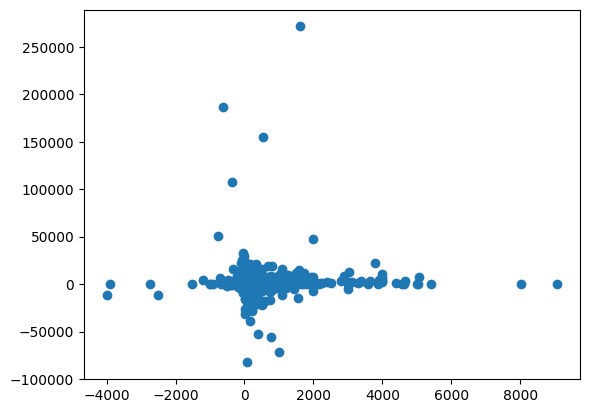

In [18]:
plt.scatter(typed_data['quantity'], typed_data['profit'])
# Looking at the plot, some data could be removed as outliers e.g. profit over 150,000 and quanitity over 8000

In [22]:
# 3 would be removed for profit 
typed_data.loc[typed_data['profit']>150_000, :]
# 2 would be removed by quantity > 0 and profit > revenue
# One more to be removed die to outlier with huge profit not comparable to revenue

,customer_id,sales_order_number,sales_order_line_number,ship_date,quantity,brand,product_type,product_supplier_id,revenue,profit,freight_cost,sales_team_name
28135,100003786,778615,10,2021-04-30,1609,Lenovo,Chromebook,1000133.0,257940.673462,271469.318895,510.3,Corporate North
204943,100001590,60251717,20,2021-12-15,-616,Lenovo,Monitors,1000133.0,-157924.951191,186305.376902,0.0,Corporate South
403302,100004472,1006165674,20,2022-12-05,522,Startech,Displayport Cables,1000171.0,140427.636176,155404.518119,0.0,Components North


In [20]:
# Two would be removed for quantity 
typed_data.loc[typed_data['quantity']>8_000, :]
# Keep these are data makes sense, would have to be sold at severe discount though

,customer_id,sales_order_number,sales_order_line_number,ship_date,quantity,brand,product_type,product_supplier_id,revenue,profit,freight_cost,sales_team_name
223175,100021359,1004621537,50,2022-01-18,9072,Flexson,Audio Stands & Mounts,1000798.0,34368.232644,-11.847830,0.0,SMB 1 South
223176,100021359,1004621537,60,2022-01-18,8004,Flexson,Audio Stands & Mounts,1000798.0,64304.362984,-18.979021,0.0,SMB 1 South


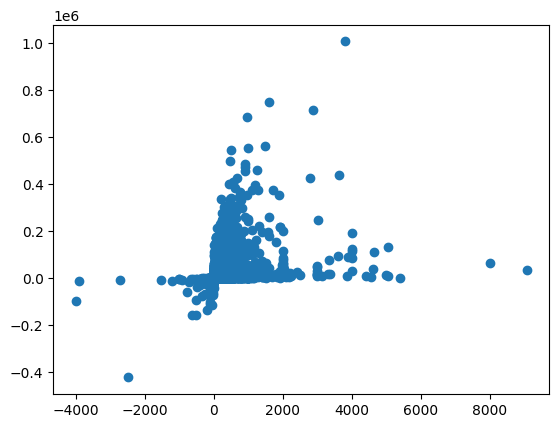

In [24]:
plt.scatter(typed_data['quantity'], typed_data['revenue'])

In [27]:
typed_data.loc[typed_data['revenue']>900_000, :]
# Keep as price makes sense

,customer_id,sales_order_number,sales_order_line_number,ship_date,quantity,brand,product_type,product_supplier_id,revenue,profit,freight_cost,sales_team_name
277079,100008538,1005439378,10,2022-06-20,3793,Lenovo,Home Notebook,1000133.0,1.004398e+06,22126.912968,0.0,Corporate South


In [37]:
grouped_count = typed_data.groupby('customer_id').count()
grouped_count.loc[grouped_count.ship_date > 5000, :]

,sales_order_number,sales_order_line_number,ship_date,quantity,brand,product_type,product_supplier_id,revenue,profit,freight_cost,sales_team_name
customer_id,,,,,,,,,,,
100000985,6832,6832,6832,6832,6832,6832,6832,6832,6832,6832,6832
100001046,9627,9627,9627,9627,9625,9625,9625,9627,9627,9627,9627
100001566,19722,19722,19722,19722,19722,19722,19722,19722,19722,19722,19722
100001570,23426,23426,23426,23426,23424,23424,23422,23426,23426,23426,23426
100001590,21818,21818,21818,21818,21808,21808,21808,21818,21818,21818,21818
100002069,9618,9618,9618,9618,9618,9618,9618,9618,9618,9618,9618
100002803,20961,20961,20961,20961,20960,20960,20960,20961,20961,20961,20961
100004472,21570,21570,21570,21570,21563,21563,21560,21570,21570,21570,21570
100004474,39551,39551,39551,39551,39548,39548,39548,39551,39551,39551,39551
